## R(t)
Calculo la evolución del bubston desde que tiene N_{e max} electrones hasta que el cluster formado por n_bubstons está en su máxima expansión.

La diferencia con el archivo _old es que en aquel tengo cuentas extras mal hechas y, además, las hice con algunos errores (factores 2/3) debido a los errores que encontré en el paper de Bunkin

El programa está construido en el sistema de unidades CGS:
https://es.wikipedia.org/wiki/Sistema_Cegesimal_de_Unidades

In [71]:
#Importo librerías
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from math import pi

### Evolución desde N_{e max} hasta R = R1

Parto de un bubston con radio R_0, temperatura T_e = Delta/3 y N_{e max} electrones en su interior. Calculo evolución del radio a partir de la ecuación fluidodinámica, empleando como presión la presión eléctrica

In [72]:
#En CGS:
#Parámetros de la ecuación diferencial
p_inf = 0.925 #Presión ambiente en el infinito en [atm]. Son 0.925 atm correspondientes a Bariloche. 
p_inf = p_inf*(101325)*(1/0.1) #en [baria] (CGS). Conversión: (atm)(101325 Pa/atm)(baria/ 0.1 Pa)
c_L = 1415.1 #velocidad del sonido del líquido en [m/s] para agua D2O a Tinf=35+273.15. Lo copié del código de Gabriela.
c_L = c_L*100 #en [cm/s] (CGS). Conversión (m/s)*(100 cm/m)
rho_L = 1101.8 #densidad del líquido en la superficie de la burbuja en [kg/m3] para agua D2O a Tinf=35+273.15. Lo copié del código de Gabriela. 
rho_L = rho_L*(1/100)**3*(1000) #en [g/cm3] (CGS). Conversión (kg/m3)*(1m/100cm)^3*(1000g/1Kg)

#Parámetros de la presión eléctrica p_e
#Condiciones iniciales de la ecuación diferencial
Delta = 6 #Energía mecánica para arrancar un electrón de la pared en [eV]
T_e_bubs_ini = Delta/3 #Temperatura de los electrones dentro de la burbuja en [eV]. Conversión: (ev)*()
T_e_bubs_ini = T_e_bubs_ini*(1.602176565e-19)*(1/1e-7) #en [erg] (CGS). Conversión (1ev)(1.602176565e-19J/1ev)*(1erg/1e-7 J)

q_e = -1.602176634e-19 #carga del electrón en [Coulomb]
q_e = q_e*(1/3.336641e-10) #en [Fr] (CGS). Conversión (C)*(Fr/3.336641e-10 C)

R0 = 1e-6 #Radio inicial de un bubston en [cm]. Este valor lo saqué del supuesto inicial del Bunkin


In [73]:
#Defino el nro máximo de electrones
def N_emax():
    return 64/9*(T_e_bubs_ini*R0/q_e**2)**2

In [74]:
#Defino electron Debye radius a_e
#a_e es solución de la ecuación de N_e asumiendo que N_e está dado por T_e, R0 y q_e al considerar x grande

from scipy.optimize import fsolve

def a_e():
    def ec_de_Ne(ae):
        return T_e_bubs_ini*R0/q_e**2*(R0/ae*np.cosh(R0/ae)- np.sinh(R0/ae))/(R0/ae) - N_emax()
    return fsolve(ec_de_Ne, 2)[0]


In [75]:
print(R0/a_e())

1.6666666666666665e-07


In [76]:
#Defino la temperatura (régimen de autoconsistencia)
def T_e(R):
    return T_e_bubs_ini*R0/R

In [77]:
#Defino la densidad de electrones

def n_e0(R):
    #En r = 0, pero depende del valor en la pared de la burbuja
    return T_e(R)/(4*pi*q_e**2*a_e()**2)

def n_e_R(R):
    #en la pared de la burbuja
    return n_e0(R)*np.sinh(R/a_e())/(R/a_e())


In [78]:
#Defino el campo eléctrico

def E(R):
    return T_e(R)*a_e()/(q_e*R**2)*(np.sinh(R/a_e()) - (R/a_e())*np.cosh(R/a_e()))

In [79]:
#Defino la presión eléctrica

def p_gas(R):
    return 2/3*n_e_R(R)*T_e(R)

def p_coul(R):
    return E(R)**2/(8*pi)

def p_e(R):
    return p_gas(R) + p_coul(R)

#### Sistema de ecuaciones diferenciales

In [80]:
def dydt(t,y):
    #Sistema de ecuaciones de primer orden para la evolución del radio en función del tiempo. Entiéndase y = (R, Rp) = (R, v_R)
    v_R = y[1]
    R = y[0]

    #Expreso dydt_0 = dR/dt = v_R
    dydt_0 = v_R

    #Expreso dydt_2 = d(v_R/dt) = d2(R)/dt2
    dydt_1 = (p_e(R)/(rho_L) - 3/2*v_R**2)/R

    
    return [dydt_0, dydt_1]

In [81]:
#Resuelvo el sistema dy/dt usando solve_ivp
t_ini = 0
t_max = 70e-2 #70 ns
y_ini = [R0, 0] #Condición inicial
rtol = 1e-12 #tolerancia relativa para el método numérico
sol = solve_ivp(dydt, [t_ini, t_max], y_ini, method = "DOP853", rtol = rtol, atol = rtol)
#asumo que el problema no es stiff


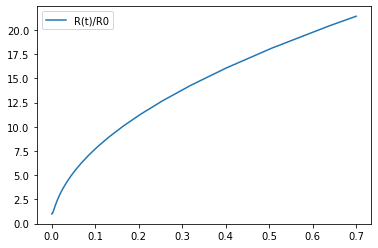

In [82]:
#Grafico
plt.plot(sol.t, sol.y[0]/R0, label = "R(t)/R0")
plt.legend()
plt.show()

HAY UN ERROR EN UN FACTOR DE PROPORCIONALIDAD

### Evolución desde formación del cluster instantánea hasta máxima expansión